In [74]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
# !ls /home/aistudio/data

In [75]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
# !ls /home/aistudio/work

In [76]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
# !mkdir /home/aistudio/external-libraries
# !pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [77]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
# import sys
# sys.path.append('/home/aistudio/external-libraries')

In [78]:
import numpy as np
import paddle
from paddle import fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

buf_size = 512
batch_size = 128
# dataloader train
train_loader = paddle.batch(paddle.reader.shuffle(paddle.dataset.mnist.train(), buf_size), batch_size=batch_size)
test_loader = paddle.batch(paddle.reader.shuffle(paddle.dataset.mnist.test(), buf_size), batch_size=batch_size)
train_data = paddle.dataset.mnist.train()
sample_data = next(train_data())
print(type(sample_data))
# image: numpy array (784,)
print(sample_data[0].shape)
# label: int
print(sample_data[1])
# print(sample_data)

<class 'tuple'>
(784,)
5


In [79]:
# multilayer perceptron
def MLP(input):
    hidden1 = fluid.layers.fc(input=input, size=512, act='leaky_relu')
    hidden2 = fluid.layers.dropout(fluid.layers.fc(input=hidden1, size=256, act='leaky_relu'), 0.2)
    hidden3 = fluid.layers.dropout(fluid.layers.batch_norm(fluid.layers.fc(input=hidden2, size=128, act=None), act='leaky_relu'), 0.2)
    hidden4 = fluid.layers.dropout(fluid.layers.batch_norm(fluid.layers.fc(input=hidden3, size=64, act=None), act='relu'), 0.1)
    prediction = fluid.layers.fc(input=hidden4, size=10, act='softmax')
    return prediction

In [80]:
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')
print(type(image))
label = fluid.layers.data(name='label', shape=[1], dtype='int64')
print(type(label))

<class 'paddle.fluid.framework.Variable'>
<class 'paddle.fluid.framework.Variable'>


In [81]:
# classifier
predict = MLP(image)
print(type(predict))

<class 'paddle.fluid.framework.Variable'>


In [82]:
# define loss and accuracy
cost = fluid.layers.cross_entropy(input=predict, label=label)
print(type(cost))
avg_cost = fluid.layers.mean(cost)
print(type(avg_cost))
acc = fluid.layers.accuracy(input=predict, label=label)
print(type(acc))

<class 'paddle.fluid.framework.Variable'>
<class 'paddle.fluid.framework.Variable'>
<class 'paddle.fluid.framework.Variable'>


In [83]:
# optimizer
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=1e-4)
# optimizer = fluid.optimizer.SGDOptimizer(learning_rate=1e-3)
opts = optimizer.minimize(avg_cost)

In [84]:
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
print(type(place))

test_program = fluid.default_main_program().clone(for_test=True)
print(type(test_program))
exe = fluid.Executor(place)
print(type(exe))
exe.run(fluid.default_startup_program())

<class 'paddle.fluid.core_avx.CUDAPlace'>
<class 'paddle.fluid.framework.Program'>
<class 'paddle.fluid.executor.Executor'>


[]

In [85]:
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])
print(type(feeder))

<class 'paddle.fluid.data_feeder.DataFeeder'>


In [86]:
# visualize
all_train_iter = 0
all_train_iters = []
all_train_costs = []
all_train_accs = []

def draw_train_process(title, iters, costs, accs, label_cost, label_acc):
    plt.title(title, fontsize=24)
    plt.xlabel('iter', fontsize=20)
    plt.ylabel('cost/acc', fontsize=20)
    plt.plot(iters, costs, color='r', label=label_cost)
    plt.plot(iters, accs, color='g', label=label_acc)
    plt.legend()
    plt.grid()
    plt.show()

Epoch: 0, Batch: 0, Cost: 2.62263, Accuracy: 0.07812
Epoch: 0, Batch: 200, Cost: 0.82577, Accuracy: 0.81250
Epoch: 0, Batch: 400, Cost: 0.48065, Accuracy: 0.89844
Test: 0, Cost: 0.37133, Accuracy: 0.92000
Epoch: 1, Batch: 0, Cost: 0.42466, Accuracy: 0.91406
Epoch: 1, Batch: 200, Cost: 0.32507, Accuracy: 0.93750
Epoch: 1, Batch: 400, Cost: 0.26242, Accuracy: 0.93750
Test: 1, Cost: 0.22188, Accuracy: 0.94422
Epoch: 2, Batch: 0, Cost: 0.27418, Accuracy: 0.92188
Epoch: 2, Batch: 200, Cost: 0.25027, Accuracy: 0.93750
Epoch: 2, Batch: 400, Cost: 0.14220, Accuracy: 0.97656
Test: 2, Cost: 0.15996, Accuracy: 0.95698
Epoch: 3, Batch: 0, Cost: 0.25262, Accuracy: 0.93750
Epoch: 3, Batch: 200, Cost: 0.14274, Accuracy: 0.97656
Epoch: 3, Batch: 400, Cost: 0.12822, Accuracy: 0.97656
Test: 3, Cost: 0.13061, Accuracy: 0.96479
Epoch: 4, Batch: 0, Cost: 0.18366, Accuracy: 0.93750
Epoch: 4, Batch: 200, Cost: 0.21986, Accuracy: 0.93750
Epoch: 4, Batch: 400, Cost: 0.11270, Accuracy: 0.98438
Test: 4, Cost: 0.

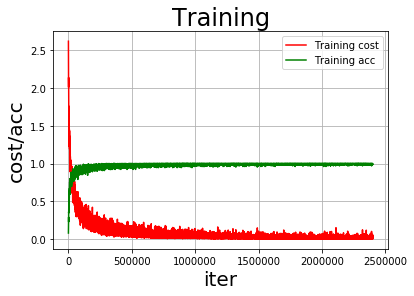

In [87]:
num_epoch = 40
model_save_dir = '/home/aistudio/work/MNIST.pth'
for epoch in range(num_epoch):
    for batch, data in enumerate(train_loader()):
        # data: list, len=batch_size
        # data[0]: tuple (image, label)
        # data[0][0]: numpy array, shape(784,)
        # data[0][1]: int, label
        train_cost, train_acc = exe.run(program=fluid.default_main_program(), feed=feeder.feed(data), fetch_list=[avg_cost, acc])
        # train_cost, train_acc: numpy array, shape (1,)

        all_train_iter += batch_size
        all_train_iters.append(all_train_iter)

        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])

        # verbose
        if batch % 200 == 0:
            print('Epoch: {}, Batch: {}, Cost: {:.5f}, Accuracy: {:.5f}'.format(epoch, batch, train_cost[0], train_acc[0]))
        
    # test
    test_accs = []
    test_costs = []
    for batch, data in enumerate(test_loader()):
        test_cost, test_acc = exe.run(program=test_program, feed=feeder.feed(data), fetch_list=[avg_cost, acc])
        test_accs.append(test_acc[0])
        test_costs.append(test_cost[0])

    # get average score
    test_cost = (sum(test_costs) / len(test_costs))
    test_acc = (sum(test_accs) / len(test_accs))
    print('Test: {}, Cost: {:.5f}, Accuracy: {:.5f}'.format(epoch, test_cost, test_acc))

# save model
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

fluid.io.save_inference_model(model_save_dir, ['image'], [predict], exe)
print('Model saved to' + model_save_dir)

print('Training progress done.')
draw_train_process('Training', all_train_iters, all_train_costs, all_train_accs, 'Training cost', 'Training acc')

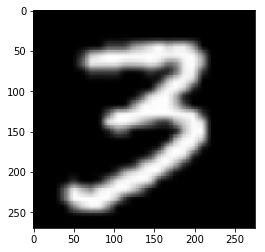

In [88]:
# load image
def load_image(file):
    # convert RGB to grey, 'L' represents grey
    img = Image.open(file).convert('L')
    img = img.resize((28, 28), Image.ANTIALIAS)
    img = np.array(img).reshape(1, 1, 28, 28).astype(np.float32)
    img = img / 255.0 * 2.0 - 1.0
    return img


img_path = '/home/aistudio/work/3.png'
img = Image.open(img_path)
plt.imshow(img)
plt.show()

In [89]:
# make predictions
infer_exe = fluid.Executor(place)
print(type(infer_exe))
infer_scope = fluid.core.Scope()
print(type(infer_scope))

with fluid.scope_guard(infer_scope):
    [infer_prog, feed_target_names, fetch_targets] = fluid.io.load_inference_model(model_save_dir, infer_exe)
    print(type(infer_prog))
    print(feed_target_names)
    print(type(fetch_targets))

    img = load_image(img_path)
    print(type(img))

    results = infer_exe.run(program=infer_prog, feed={feed_target_names[0]: img}, fetch_list=fetch_targets)
    # results: list

    pred_label = np.argmax(results)
    print('Predicted label: {}'.format(pred_label))

<class 'paddle.fluid.executor.Executor'>
<class 'paddle.fluid.core_avx._Scope'>
<class 'paddle.fluid.framework.Program'>
['image']
<class 'list'>
<class 'numpy.ndarray'>
Predicted label: 3


In [90]:
# test on entire test set
test_accs = []
test_costs = []
for batch, data in enumerate(test_loader()):
    test_cost, test_acc = exe.run(program=test_program, feed=feeder.feed(data), fetch_list=[avg_cost, acc])
    test_accs.append(test_acc[0])
    test_costs.append(test_cost[0])

# get average score
test_cost = (sum(test_costs) / len(test_costs))
test_acc = (sum(test_accs) / len(test_accs))
print('Test Accuracy: {:.5f}'.format(test_acc))

Test Accuracy: 0.98072


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 